# Credit Risk Analysis

This notebook analyses the dataset on credit risk (which can be found [here](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset/data)) in order to predict the loan status of a given customer.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [26]:
credit_df = pd.read_csv("./data/loan/loan.csv")

/tmp/ipykernel_19808/1856421531.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_df = pd.read_csv("./data/loan/loan.csv")


## Data cleaning

This dataset has 887379 rows and 74 features. The target feature of interest is `loan_status` which is a categorical feature.

In [27]:
display(credit_df["loan_status"])

0          Fully Paid
1         Charged Off
2          Fully Paid
3          Fully Paid
4             Current
             ...     
887374        Current
887375        Current
887376        Current
887377        Current
887378        Current
Name: loan_status, Length: 887379, dtype: object

Some features are not useful so we just drop them

In [28]:
columns_to_drop = ["url", "id", "member_id", "emp_title"]
credit_df = credit_df.drop(columns_to_drop, axis=1)

We see the distribution of loan status is mostly spread over three values. The lack of data for the other categories makes it difficult to train a model for them. What we will do is create 4 useful categories `ongoing`, `successful`, `failure` which will gather the various subcases.

0

<Axes: xlabel='Count', ylabel='loan_status'>

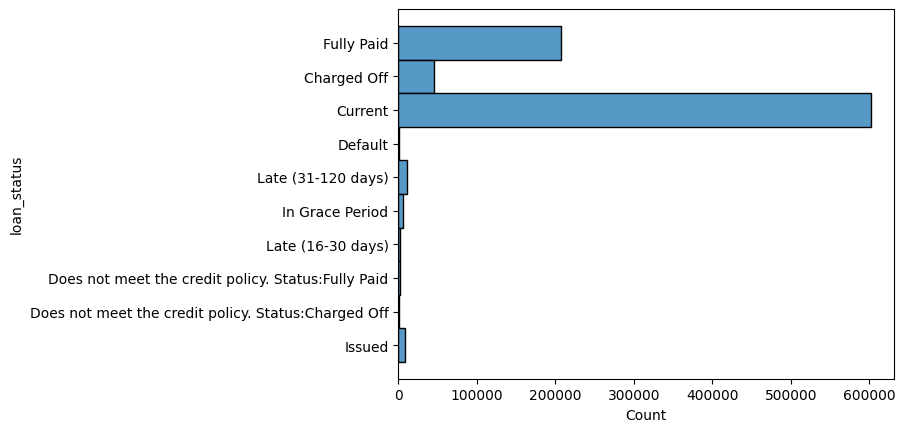

In [29]:
display(credit_df["loan_status"].isnull().sum())  # There are no missing entries
sns.histplot(y=credit_df["loan_status"])

<Axes: xlabel='Count', ylabel='loan_status'>

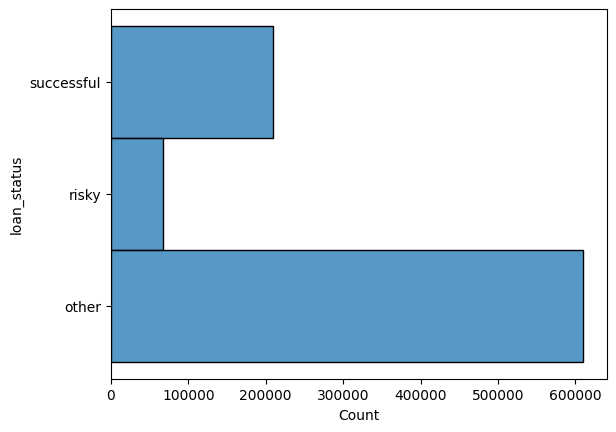

In [30]:
loan_status_categories = {
    "Fully Paid": "successful",
    "Charged Off": "risky",
    "Current": "other",
    "Default": "risky",
    "Late (31-120 days)": "risky",
    "In Grace Period": "risky",
    "Late (16-30 days)": "risky",
    "Does not meet the credit policy. Status:Fully Paid": "successful",
    "Does not meet the credit policy. Status:Charged Off": "risky",
    "Issued": "other",
}
credit_df["loan_status"] = credit_df["loan_status"].map(loan_status_categories)
sns.histplot(y=credit_df["loan_status"])

In [31]:
risky_or_not_risky = credit_df["loan_status"] != "other"
credit_df_filtered = credit_df[risky_or_not_risky]
X = credit_df_filtered.drop("loan_status", axis=1)
y = credit_df_filtered["loan_status"]

We now look at all the missing features in the dataset.

In [32]:
number_missing_features = credit_df.isnull().sum()
missing_features_proportion = (
    number_missing_features[number_missing_features > 0] / len(credit_df.index)
).sort_values(ascending=False)
display(missing_features_proportion)

dti_joint                      0.999426
annual_inc_joint               0.999424
verification_status_joint      0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
total_cu_tl                    0.975916
inq_fi                         0.975916
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_last_12m                   0.975916
desc                           0.857980
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
next_pymnt_d                   0.285077
total_rev_hi_lim               0.079195
tot_coll_amt                   0.079195
tot_cur_bal                    0.079195


We see a few features are missing a majority of their values, so for these we will replace them by a boolean column.

In [33]:
missing_features_proportion_over_threshold = missing_features_proportion > 0.85
missing_features_proportion_over_threshold_names = list(
    missing_features_proportion_over_threshold[missing_features_proportion_over_threshold].index
)


def replace_feature_boolean(df, col):
    df[col + "_is_na"] = df[col].isna()
    df.drop(col, axis=1, inplace=True)


for col in missing_features_proportion_over_threshold_names:
    replace_feature_boolean(X, col)

In [34]:
missing_features_proportion_under_threshold = missing_features_proportion <= 0.85
missing_features_proportion_under_threshold_names = list(
    missing_features_proportion_under_threshold[missing_features_proportion_under_threshold].index
)

display(len(missing_features_proportion_under_threshold_names))

21

We still have 22 features with missing values which we need to somehow fill.

In [35]:
missing_features_proportion_under_threshold_names

['mths_since_last_record',
 'mths_since_last_major_derog',
 'mths_since_last_delinq',
 'next_pymnt_d',
 'total_rev_hi_lim',
 'tot_coll_amt',
 'tot_cur_bal',
 'emp_length',
 'last_pymnt_d',
 'revol_util',
 'title',
 'collections_12_mths_ex_med',
 'last_credit_pull_d',
 'total_acc',
 'open_acc',
 'acc_now_delinq',
 'inq_last_6mths',
 'earliest_cr_line',
 'delinq_2yrs',
 'pub_rec',
 'annual_inc']

We also need to clean some features like `emp_length` before imputation and encoding.

In [36]:
def clean_emp_length(x):
    if pd.isna(x):
        return x
    if x == "< 1 year":
        return 0
    elif x == "1 year":
        return 1
    elif x == "10+ years":
        return 10
    else:
        return int(x.replace(" years", ""))


X["emp_length"] = X["emp_length"].apply(clean_emp_length)


def clean_zip_code(x):
    if pd.isna(x):
        return x
    else:
        return int(x.replace("xx", ""))


X["zip_code"] = X["zip_code"].apply(clean_zip_code)

In [53]:
def analyze_column(col):
    print(len(X[col].unique()))
    print(X[col].dropna().dtype)


# analyze_column("total_rev_hi_lim")

By looking at the distribution of the various features with missing entries, we decide which scheme to use for the imputers.

In [54]:
columns_impute_median = [
    "mths_since_last_major_derog",
    "mths_since_last_delinq",
    "open_acc",
    "annual_inc",
    "total_rev_hi_lim",
    "mths_since_last_record",
    "emp_length",
]
columns_impute_most_frequent = [
    "tot_coll_amt",
    "tot_cur_bal",
    "revol_util",
    "collections_12_mths_ex_med",
    "inq_last_6mths",
    "delinq_2yrs",
    "total_acc",
    "pub_rec",
    "acc_now_delinq",
]
columns_impute_extra_label = [
    "last_pymnt_d",
    "next_pymnt_d",
    "title",
    "last_credit_pull_d",
    "earliest_cr_line",
]

We now create some pipelines to automatically fill these and encode these values.

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [56]:
# Imputers
median_imputer = SimpleImputer(strategy="median")
most_frequent_imputer = SimpleImputer(strategy="most_frequent")
extra_label_imputer = SimpleImputer(strategy="constant", fill_value="Missing")

preprocessor_imputer = ColumnTransformer(
    transformers=[
        ("median", median_imputer, columns_impute_median),
        ("most_frequent", most_frequent_imputer, columns_impute_most_frequent),
        ("extra_label", extra_label_imputer, columns_impute_extra_label),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessor_imputer.set_output(transform="pandas")

# There are two different kinds of columns
categorical_columns = list(X.dropna().select_dtypes("object").columns)
number_labels_cat_features = X[categorical_columns].nunique()
categorical_columns_oh = list(number_labels_cat_features[number_labels_cat_features < 15].index)
categorical_columns_od = list(number_labels_cat_features[number_labels_cat_features >= 15].index)
numerical_columns = list(X.dropna().select_dtypes(exclude="object").columns)


preprocessor_encoder = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat_oh", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns_oh),
        ("cat_od", OrdinalEncoder(), categorical_columns_od),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessor_encoder.set_output(transform="pandas")

# Now we combine the two processes
pipeline = Pipeline(steps=[("imputer", preprocessor_imputer), ("encoder", preprocessor_encoder)])

In [59]:
X_preprocessed = pipeline.fit_transform(X)

In [60]:
y_processed = pd.Categorical(y, categories=["successful", "risky"]).codes

# Prediction

We will now start with a baseline prediction using our pre-processed dataset

At first we will use a RandomForest classifier as baseline, before moving towards more fancy models like xgboost.

In [87]:
from sklearn.model_selection import train_test_split, ValidationCurveDisplay

X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed, y_processed, test_size=0.3, random_state=42)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    classification_report,
)

In [62]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
model_rf.fit(X_train, y_train)

y_predict = model_rf.predict(X_valid)

0.9974621731495513

0.9948018033554236

In [92]:
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62741
           1       1.00      0.99      0.99     20401

    accuracy                           1.00     83142
   macro avg       1.00      0.99      1.00     83142
weighted avg       1.00      1.00      1.00     83142



In [86]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=2,
    learning_rate=0.2,
    subsample=0.3,
    n_estimators=1000,
    early_stopping_rounds=5,
)

model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

y_predict_xgb = model_xgb.predict(X_valid)[:, 1]

[0]	validation_0-mlogloss:0.51934
[1]	validation_0-mlogloss:0.40509
[2]	validation_0-mlogloss:0.32035
[3]	validation_0-mlogloss:0.25632
[4]	validation_0-mlogloss:0.20905
[5]	validation_0-mlogloss:0.17127
[6]	validation_0-mlogloss:0.14096
[7]	validation_0-mlogloss:0.11723
[8]	validation_0-mlogloss:0.09864
[9]	validation_0-mlogloss:0.08405
[10]	validation_0-mlogloss:0.06995
[11]	validation_0-mlogloss:0.05925
[12]	validation_0-mlogloss:0.05035
[13]	validation_0-mlogloss:0.04290
[14]	validation_0-mlogloss:0.03685
[15]	validation_0-mlogloss:0.03200
[16]	validation_0-mlogloss:0.02771
[17]	validation_0-mlogloss:0.02428
[18]	validation_0-mlogloss:0.02185
[19]	validation_0-mlogloss:0.01946
[20]	validation_0-mlogloss:0.01786
[21]	validation_0-mlogloss:0.01666
[22]	validation_0-mlogloss:0.01496
[23]	validation_0-mlogloss:0.01377
[24]	validation_0-mlogloss:0.01245
[25]	validation_0-mlogloss:0.01157
[26]	validation_0-mlogloss:0.01085
[27]	validation_0-mlogloss:0.01010
[28]	validation_0-mlogloss:0.0

0.9990257631521975

0.9980109520418436

In [93]:
print(classification_report(y_valid, y_predict_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62741
           1       1.00      1.00      1.00     20401

    accuracy                           1.00     83142
   macro avg       1.00      1.00      1.00     83142
weighted avg       1.00      1.00      1.00     83142



For some reason both models yield results which are too good, implying overfitting. This must be investigated.